In [2]:
import pandas as pd
import nltk
import matplotlib.pyplot as plt
import numpy as np

In [4]:
train = pd.read_csv('train.tsv', sep='\t')
train.head()

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2


In [5]:
# load test dataset
test = pd.read_csv('test.tsv', sep='\t')
test.head()

,PhraseId,SentenceId,Phrase
0,156061,8545,An intermittently pleasing but mostly routine ...
1,156062,8545,An intermittently pleasing but mostly routine ...
2,156063,8545,An
3,156064,8545,intermittently pleasing but mostly routine effort
4,156065,8545,intermittently pleasing but mostly routine


Data Exploration

In [8]:
print(train.shape)
print(test.shape)

(156060, 4)
(66292, 3)


In [9]:
train.isnull().sum()

PhraseId      0
SentenceId    0
Phrase        0
Sentiment     0
dtype: int64

In [10]:
sentiment_phrase = []

for row in train['Sentiment']:
    if row == 0:
        sentiment_phrase.append('Negative')
    elif row == 1:
        sentiment_phrase.append('Somewhat Negative')
    elif row == 2:
        sentiment_phrase.append('Neutral')
    elif row == 3:
        sentiment_phrase.append('Somewhat Positive')
    elif row == 4:
        sentiment_phrase.append('Positive')
    else:
        sentiment_phrase.append('Fail')

train['Sentiment Phrase'] = sentiment_phrase

In [12]:
train.head()

,PhraseId,SentenceId,Phrase,Sentiment,Sentiment Phrase
0,1,1,A series of escapades demonstrating the adage ...,1,Somewhat Negative
1,2,1,A series of escapades demonstrating the adage ...,2,Neutral
2,3,1,A series,2,Neutral
3,4,1,A,2,Neutral
4,5,1,series,2,Neutral


In [13]:
train['Sentiment'].value_counts()

2    79582
3    32927
1    27273
4     9206
0     7072
Name: Sentiment, dtype: int64

In [14]:
phrase_count = pd.value_counts(train['Sentiment Phrase'].values)
phrase_count

Neutral              79582
Somewhat Positive    32927
Somewhat Negative    27273
Positive              9206
Negative              7072
dtype: int64

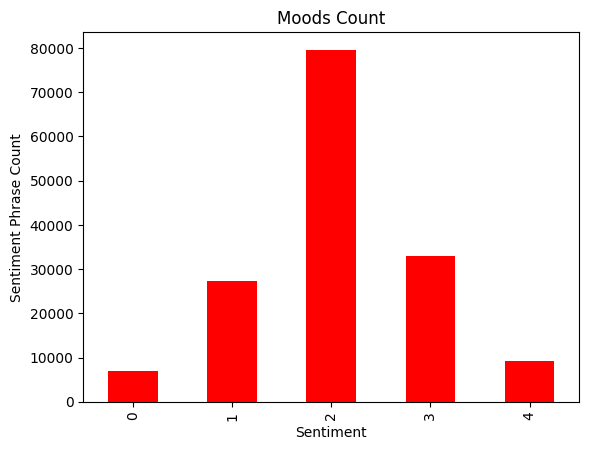

In [19]:
train['Sentiment'].value_counts().sort_index().plot(kind='bar', color= 'red')
plt.ylabel('Sentiment Phrase Count')
plt.xlabel('Sentiment')
plt.title('Moods Count');

In [20]:
wordCount = train['Phrase'].apply(lambda x: len(x.split()))
wordCount.describe()
print(train['Sentiment'].value_counts(normalize=True).sort_index())

0    0.045316
1    0.174760
2    0.509945
3    0.210989
4    0.058990
Name: Sentiment, dtype: float64


In [23]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import TfidfVectorizer

In [24]:
stemmer = SnowballStemmer(language='english')
stop_words = stopwords.words('english')
stop_words.remove('not')
lemmatizer = WordNetLemmatizer()

In [25]:
def tokenize(text):
    return [stemmer.stem(token) for token in word_tokenize(text)]

tokenize("I like this movie so much. It makes me feel so romance")

['i',
 'like',
 'this',
 'movi',
 'so',
 'much',
 '.',
 'it',
 'make',
 'me',
 'feel',
 'so',
 'romanc']

Text pre-processing

In [26]:
import re

In [27]:
def text_preprocess(Phrase):
    Phrase = re.sub(re.compile('<.*?>'), '', Phrase)
    Phrase =  re.sub('[^A-Za-z0-9]+', ' ', Phrase)
    Phrase = Phrase.lower()
    tokens = nltk.word_tokenize(Phrase)
    Phrase = [word for word in tokens if word not in stop_words]
    Phrase = [lemmatizer.lemmatize(word) for word in Phrase]
    Phrase = ' '.join(Phrase)

    return Phrase

In [28]:
train['PreProcess Phrase'] = train['Phrase'].apply(lambda Phrase: text_preprocess(Phrase))
train.head()

,PhraseId,SentenceId,Phrase,Sentiment,Sentiment Phrase,PreProcess Phrase
0,1,1,A series of escapades demonstrating the adage ...,1,Somewhat Negative,series escapade demonstrating adage good goose...
1,2,1,A series of escapades demonstrating the adage ...,2,Neutral,series escapade demonstrating adage good goose
2,3,1,A series,2,Neutral,series
3,4,1,A,2,Neutral,
4,5,1,series,2,Neutral,series


Splitting test & train data

In [29]:
from sklearn.model_selection import train_test_split

train_df = train.copy()
y = train_df['Sentiment'].values
train_df.drop(['Sentiment'], axis=1, inplace=True)

X_train, X_test, y_train, y_test = train_test_split(train_df, y, test_size=0.2, stratify=y)

print("Train data:",  X_train.shape, y_train.shape)
print("Test data:",  X_test.shape, y_test.shape)

Train data: (124848, 5) (124848,)
Test data: (31212, 5) (31212,)


In [31]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()

X_train_phrase_bow = vectorizer.fit_transform(X_train['PreProcess Phrase'])
X_test_phrase_bow = vectorizer.transform(X_test['PreProcess Phrase'])

print('X_train_phrase_bow shape: ', X_train_phrase_bow.shape)
print('X_test_phrase_bow shape: ', X_test_phrase_bow.shape)

X_train_phrase_bow shape:  (124848, 13727)
X_test_phrase_bow shape:  (31212, 13727)


In [32]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score

clf = MultinomialNB()
clf.fit(X_train_phrase_bow, y_train)

y_pred = clf.predict(X_test_phrase_bow) #prediction from model
print('Test Accuracy: ', accuracy_score(y_test, y_pred)) 

Test Accuracy:  0.6140266564141996


Compare Multiple modal accuracy

In [34]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()

X_train_phrase_tfidf = vectorizer.fit_transform(X_train['PreProcess Phrase'])
X_test_phrase_tfidf = vectorizer.transform(X_test['PreProcess Phrase'])

print('X_train_phrase_tfidf shape: ', X_train_phrase_tfidf.shape)
print('X_test_phrase_tfidf shape: ', X_test_phrase_tfidf.shape)

X_train_phrase_tfidf shape:  (124848, 13727)
X_test_phrase_tfidf shape:  (31212, 13727)


In [35]:
lf = MultinomialNB(alpha=1)
clf.fit(X_train_phrase_tfidf, y_train)

y_pred = clf.predict(X_test_phrase_tfidf)
print('Test Accuracy: ', accuracy_score(y_test, y_pred))

Test Accuracy:  0.5879469434832757


In [36]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(penalty='l2')
clf.fit(X_train_phrase_tfidf, y_train)

y_pred = clf.predict(X_test_phrase_tfidf)
print('Test Accuracy: ', accuracy_score(y_test, y_pred))

Test Accuracy:  0.629437395873382


c:\Users\jangj\anaconda3\envs\JJ\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
